In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.inspection import DecisionBoundaryDisplay

from scipy import stats

from src.visualization import feature_importances_plot

# warnings -> to silence warnings
import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(precision=5, suppress=True)

RANDOM_STATE = 42
N_JOBS = -1
class_names = ["Canis", "Dysg. Equisimilis", "Dysg. Dysgalactiae"]

map_target = {
    "Streptococcus canis": 0,
    "Streptococcus dysgalactiae subsp. equisimilis": 1,
    "Streptococcus dysgalactiae subsp. dysgalactiae": 2
}

map_target_inv = {
    0: "Strept. canis",
    1: "Strept. dysg. equisimilis",
    2: "Strept. dysg. dysgalactiae"
}

df = pd.read_csv("data/Dati_Matemaldomics_46picchi.csv",
                 delimiter=';', index_col='ID Strain')
maldi = df[df.columns[9:55]]

df['target'] = df["Putative Subspecies"].map(map_target)

maldi.fillna(0, inplace=True)
maldi = maldi.replace(',', '.', regex=True)
columns = maldi.columns
for column in columns:
    maldi[column] = maldi[column].astype(float)
maldi

y = df['target']
X = maldi
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
mm = MinMaxScaler()
ss = StandardScaler()

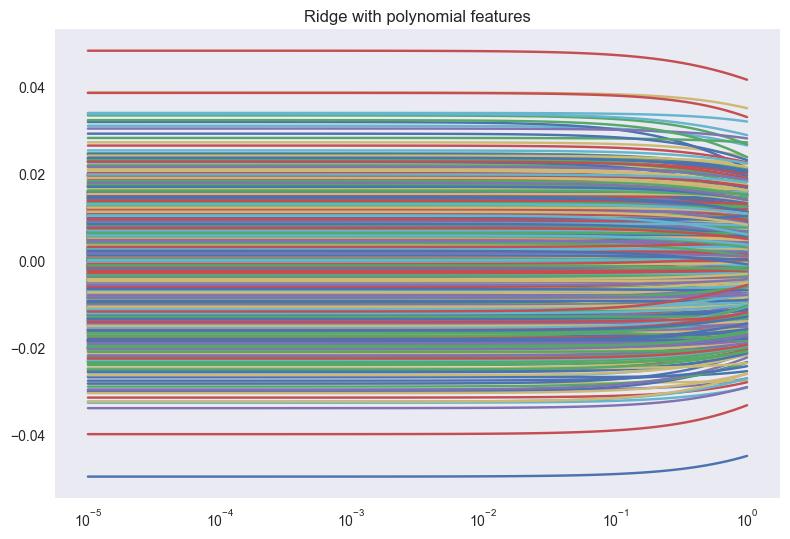

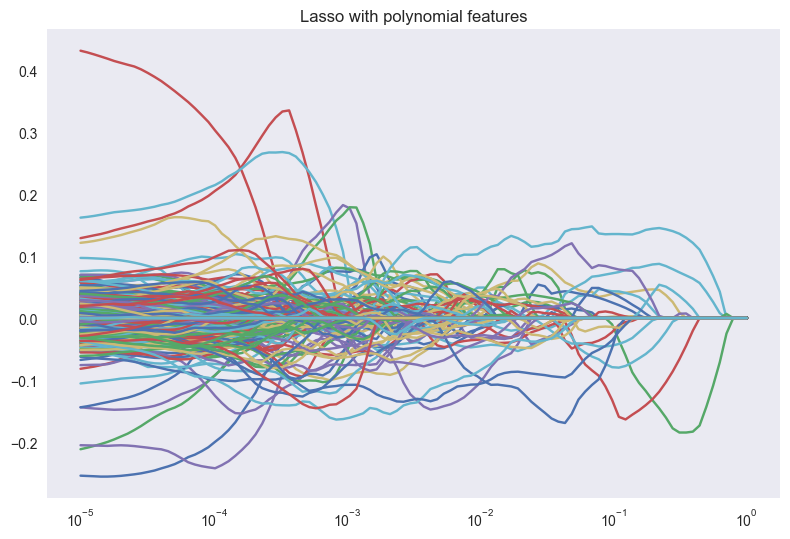

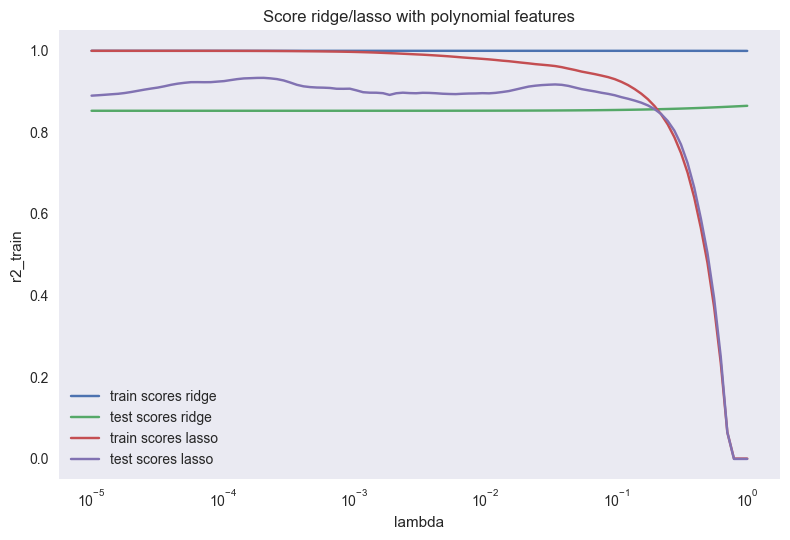

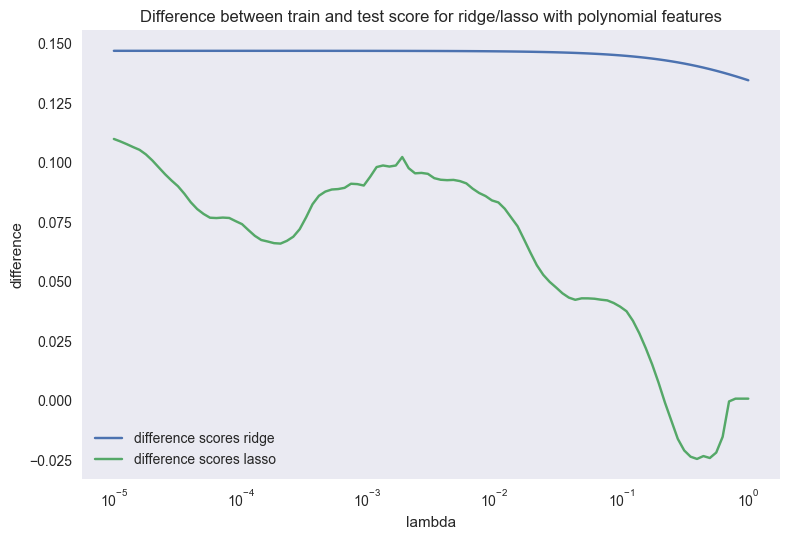

In [62]:
alphas = np.logspace(-5, 0, 100)
coefs_ridge = []
metrics_ridge = []
coefs_lasso = []
metrics_lasso = []

#Crea feature polinomiali di grado 2
#Prova usando alpha che varia tra 10^-5 a 10^0, la ridge e la lasso e confronta i risultati 
for alpha in alphas:
    po_ridge = Pipeline(
    steps=[
        ("Poly", PolynomialFeatures(degree=2)),
        ("Scaler", StandardScaler()),
        ("Model", Ridge(alpha=alpha))
    ])
    po_ridge.fit(X_train, y_train)
    #print(po_ridge.named_steps["Model"].coef_)
    coefs_ridge.append(po_ridge.named_steps["Model"].coef_)
    metrics_ridge.append({"lambda": alpha, "r2_train": po_ridge.score(X_train, y_train), "r2_test": po_ridge.score(X_test, y_test)})
    po_lasso = Pipeline(
    steps=[
        ("Poly", PolynomialFeatures(degree=2)),
        ("Scaler", StandardScaler()),
        ("Model", Lasso(alpha=alpha))
    ])
    po_lasso.fit(X_train, y_train)
    #print(po_ridge.named_steps["Model"].coef_)
    coefs_lasso.append(po_lasso.named_steps["Model"].coef_)
    metrics_lasso.append({"lambda": alpha, "r2_train": po_lasso.score(X_train, y_train), "r2_test": po_lasso.score(X_test, y_test)})
    
plt.plot(alphas, coefs_ridge)
plt.xscale("log")
plt.title("Ridge with polynomial features")
plt.tight_layout()
plt.grid()
plt.show()

plt.plot(alphas, coefs_lasso)
plt.xscale("log")
plt.title("Lasso with polynomial features")
plt.tight_layout()
plt.grid()
plt.show()

df_metrics_ridge = pd.DataFrame(metrics_ridge)
df_metrics_ridge["difference"] = df_metrics_ridge["r2_train"] - df_metrics_ridge["r2_test"]

df_metrics_lasso = pd.DataFrame(metrics_lasso)
df_metrics_lasso["difference"] = df_metrics_lasso["r2_train"] - df_metrics_lasso["r2_test"]

sns.lineplot(data=df_metrics_ridge, x="lambda", y="r2_train", label="train scores ridge")
sns.lineplot(data=df_metrics_ridge, x="lambda", y="r2_test", label="test scores ridge")
sns.lineplot(data=df_metrics_lasso, x="lambda", y="r2_train", label="train scores lasso")
sns.lineplot(data=df_metrics_lasso, x="lambda", y="r2_test", label="test scores lasso")
plt.xscale("log")
plt.title("Score ridge/lasso with polynomial features")
plt.grid()
plt.tight_layout()
plt.show()

sns.lineplot(data=df_metrics_ridge, x="lambda", y="difference", label="difference scores ridge")
sns.lineplot(data=df_metrics_lasso, x="lambda", y="difference", label="difference scores lasso")
plt.xscale("log")
plt.title("Difference between train and test score for ridge/lasso with polynomial features")
plt.grid()
plt.tight_layout()
plt.show()

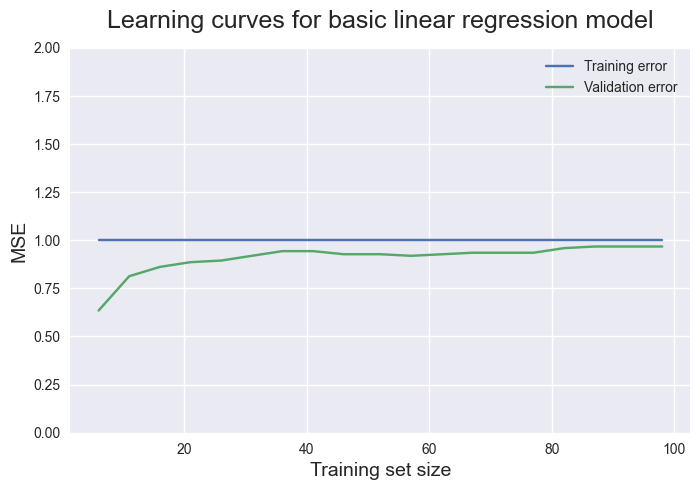

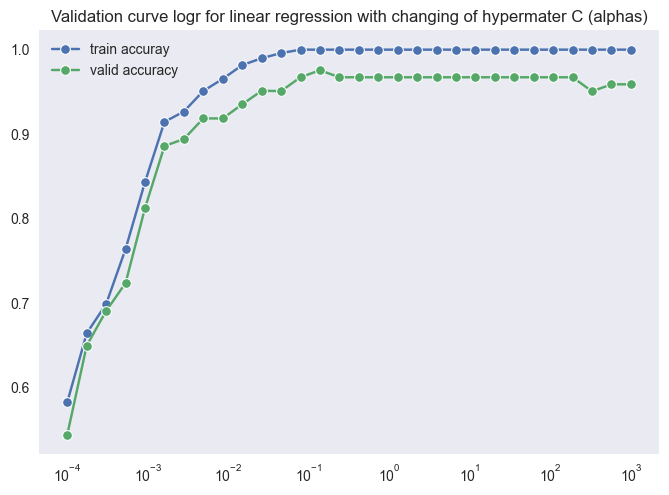

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Mean CV accuracy: 0.9753 +/- 0.0201
[1.      0.96    1.      0.95833 0.95833]


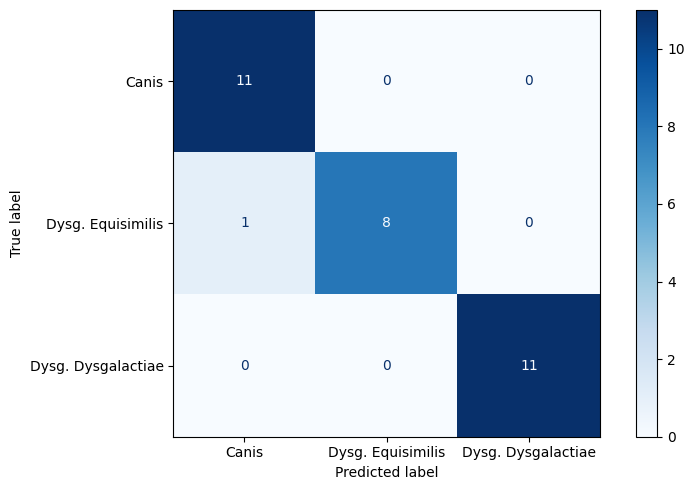

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.89      0.94         9
           2       1.00      1.00      1.00        11

    accuracy                           0.97        31
   macro avg       0.97      0.96      0.97        31
weighted avg       0.97      0.97      0.97        31



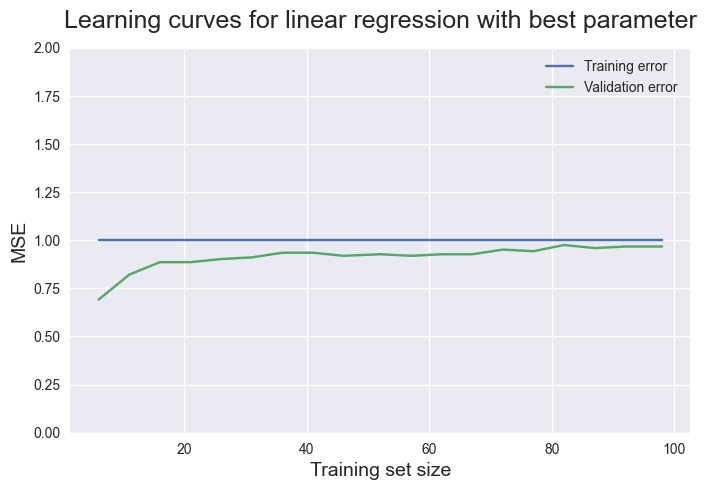

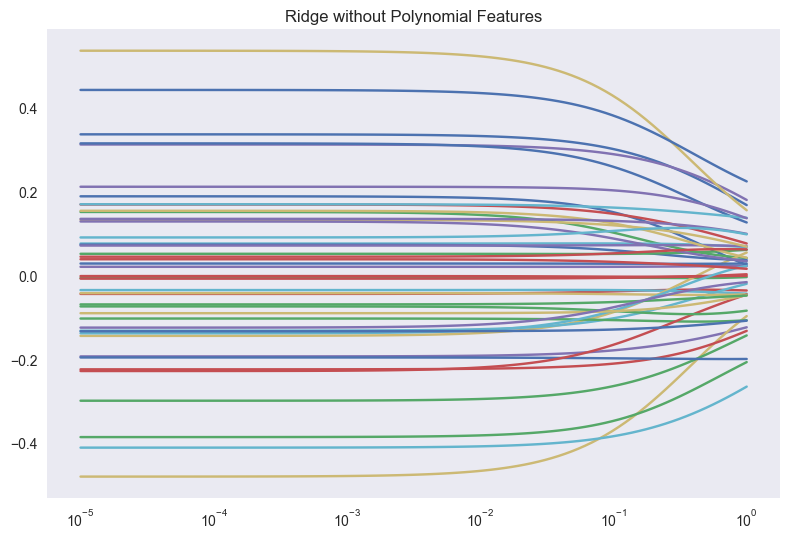

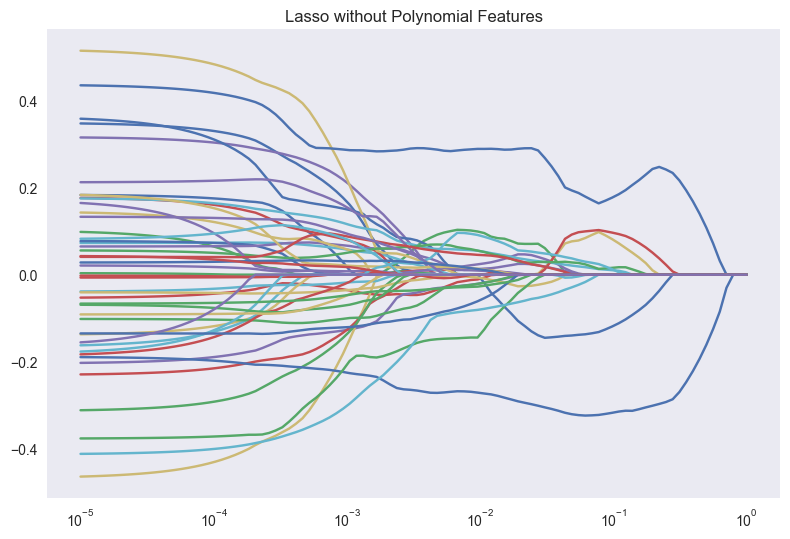

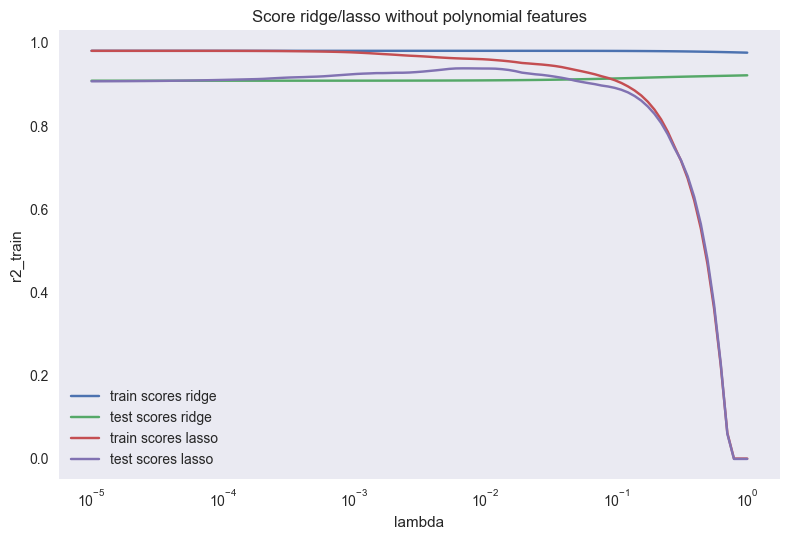

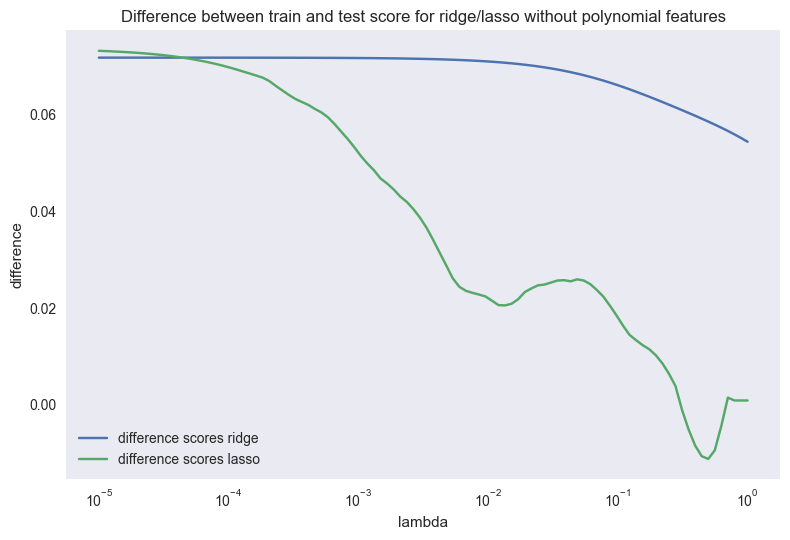

In [63]:
#Scala i dati
X_train = ss.fit_transform(X=X_train)
X_test = ss.transform(X=X_test)

#Prova regressione logistica non modificando gli iperparametri e misura la learning curve
logr = LogisticRegression()
train_sizes = np.linspace(0.01, 1, 20)

train_sizes, train_scores, valid_scores = learning_curve(estimator=logr, X=X_train, y=y_train,
                                                         train_sizes=train_sizes, cv=5,
                                                         scoring="accuracy", n_jobs=-1, shuffle=True, random_state=42)

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

plt.style.use('seaborn')
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Training error')
plt.plot(train_sizes, valid_mean, label='Validation error')
plt.ylabel('MSE', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves for basic linear regression model',
          fontsize=18, y=1.03)
plt.ylim(0, 2)
plt.legend()
plt.show()

#per alpha tra -4 e 100 calcola il validation curve al variare del parametro c
alphas = np.logspace(start=-4, stop=3, num=30)

train_scores, valid_scores = validation_curve(estimator=logr, X=X_train, y=y_train,
                                              param_name="C", param_range=alphas, cv=5,
                                              scoring="accuracy", n_jobs=-1)

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

sns.lineplot(x=alphas, y=train_mean, marker="o", label="train accuray")
sns.lineplot(x=alphas, y=valid_mean,
             marker="o", label="valid accuracy")
plt.xscale("log")
plt.grid()
plt.title("Validation curve logr for linear regression with changing of hypermater C (alphas)")
plt.show()

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Con RandomSearch misura parametri migliori per regressione logistica
params = {
    "penalty": ["l2", "l1"],
    "C": stats.loguniform(1e0, 1e2),
    "class_weight": [None, "balanced"]
}

rs = RandomizedSearchCV(estimator=logr, param_distributions=params,
                        scoring="accuracy", n_jobs=-1, cv=skfold, verbose=1)
rs.fit(X_train, y_train)
print(rs.b)
#utilizza i parametri trovati per creare un nuovo modello di reg log
logr_best = LogisticRegression(**rs.best_params_)
logr_best.fit(X_train, y_train)

logr_cv_scores = cross_val_score(estimator=logr_best, X=X_train, y=y_train,
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV accuracy: {logr_cv_scores.mean():.4f} +/- {logr_cv_scores.std():.4f}")
print(logr_cv_scores)

fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(estimator=logr_best, X=X_test, y_true=y_test,
                      cmap='Blues', display_labels=class_names, ax=ax)
plt.title("Logistic regression with best params")
plt.tight_layout()
plt.show()

y_pred = logr_best.predict(X_test)
accuracy_logic = logr_best.score(X_test, y_test)
report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

#Misura il learning curve del nuovo modello
train_sizes, train_scores, valid_scores = learning_curve(estimator=logr_best, X=X_train, y=y_train,
                                                         train_sizes=train_sizes, cv=5,
                                                         scoring="accuracy", n_jobs=-1, shuffle=True, random_state=42)

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

plt.style.use('seaborn')
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Training error')
plt.plot(train_sizes, valid_mean, label='Validation error')
plt.ylabel('MSE', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves for linear regression with best parameter',
          fontsize=18, y=1.03)
plt.ylim(0, 2)
plt.legend()
plt.show()

alphas = np.logspace(-5, 0, 100)
coefs_ridge = []
metrics_ridge = []
coefs_lasso = []
metrics_lasso = []

#Rifa ridge e lasso ma questa volta direttamente su le feature, senza polynomial features
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    coefs_ridge.append(ridge.coef_)
    metrics_ridge.append({"lambda": alpha, "r2_train": ridge.score(X_train, y_train), "r2_test": ridge.score(X_test, y_test)})
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    coefs_lasso.append(lasso.coef_)
    metrics_lasso.append({"lambda": alpha, "r2_train": lasso.score(X_train, y_train), "r2_test": lasso.score(X_test, y_test)})
    
plt.plot(alphas, coefs_ridge)
plt.xscale("log")
plt.title("Ridge without Polynomial Features")
plt.tight_layout()
plt.grid()
plt.show()

plt.plot(alphas, coefs_lasso)
plt.xscale("log")
plt.title("Lasso without Polynomial Features")
plt.tight_layout()
plt.grid()
plt.show()

df_metrics_ridge = pd.DataFrame(metrics_ridge)
df_metrics_ridge["difference"] = df_metrics_ridge["r2_train"] - df_metrics_ridge["r2_test"]

df_metrics_lasso = pd.DataFrame(metrics_lasso)
df_metrics_lasso["difference"] = df_metrics_lasso["r2_train"] - df_metrics_lasso["r2_test"]

sns.lineplot(data=df_metrics_ridge, x="lambda", y="r2_train", label="train scores ridge")
sns.lineplot(data=df_metrics_ridge, x="lambda", y="r2_test", label="test scores ridge")
sns.lineplot(data=df_metrics_lasso, x="lambda", y="r2_train", label="train scores lasso")
sns.lineplot(data=df_metrics_lasso, x="lambda", y="r2_test", label="test scores lasso")
plt.xscale("log")
plt.title("Score ridge/lasso without polynomial features")
plt.grid()
plt.tight_layout()
plt.show()

sns.lineplot(data=df_metrics_ridge, x="lambda", y="difference", label="difference scores ridge")
sns.lineplot(data=df_metrics_lasso, x="lambda", y="difference", label="difference scores lasso")
plt.xscale("log")
plt.title("Difference between train and test score for ridge/lasso without polynomial features")
plt.grid()
plt.tight_layout()
plt.show()

Profonfità albero: 4


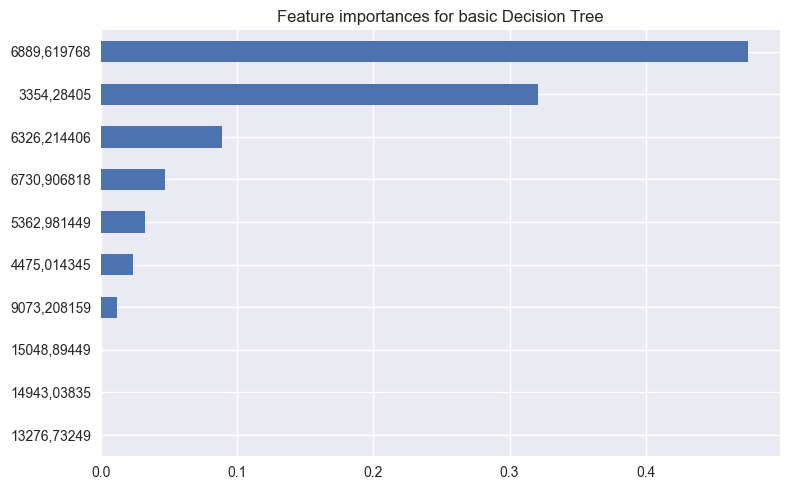

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Mean CV accuracy: 0.9513 +/- 0.0157
[0.96    0.92    0.96    0.95833 0.95833]


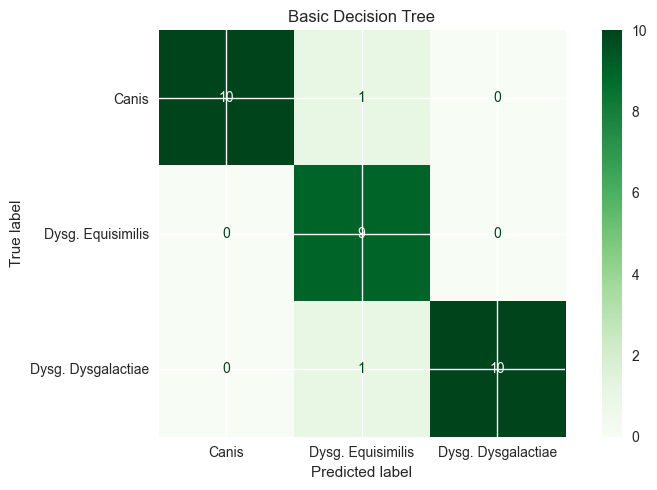

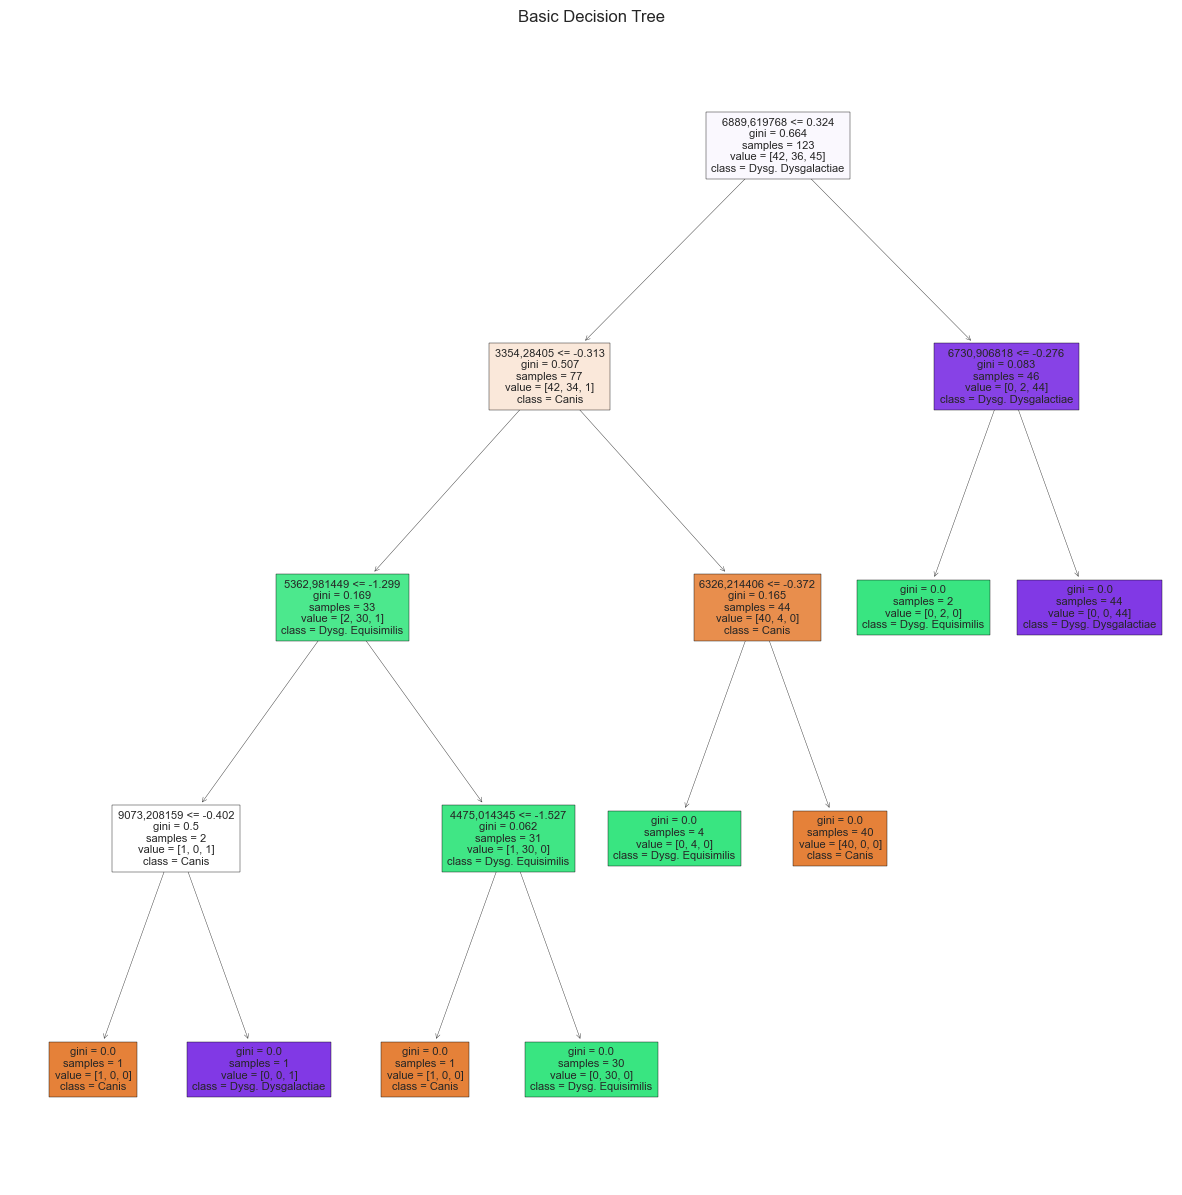

train accuracy score: 1.0000
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.82      1.00      0.90         9
           2       1.00      0.91      0.95        11

    accuracy                           0.94        31
   macro avg       0.94      0.94      0.93        31
weighted avg       0.95      0.94      0.94        31



,ccp,train,test
0,0.0,1.000000,0.935484
1,0.008130081300813009,0.991870,0.935484
2,0.015735641227380005,0.983740,0.935484
3,0.021465639876340106,0.975610,0.935484
4,0.03110639802050195,0.959350,0.903226
5,0.05912786400591279,0.926829,0.903226
6,0.21314187167845705,0.699187,0.677419
7,0.31518304523503293,0.365854,0.354839


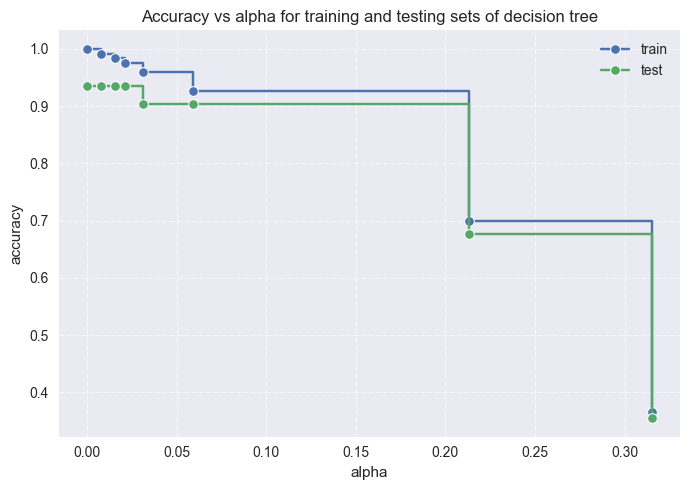

Profonfità albero con ccp=0.0214: 3


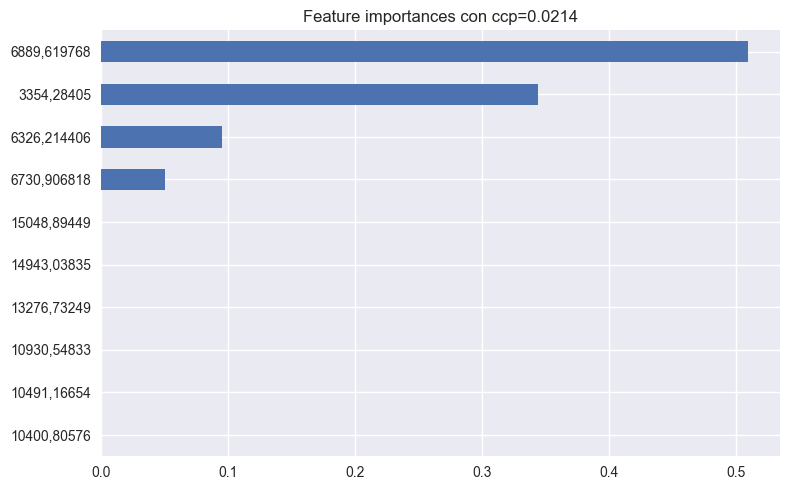

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Mean CV accuracy: 0.9267 +/- 0.0312
[0.96    0.92    0.92    0.95833 0.875  ]


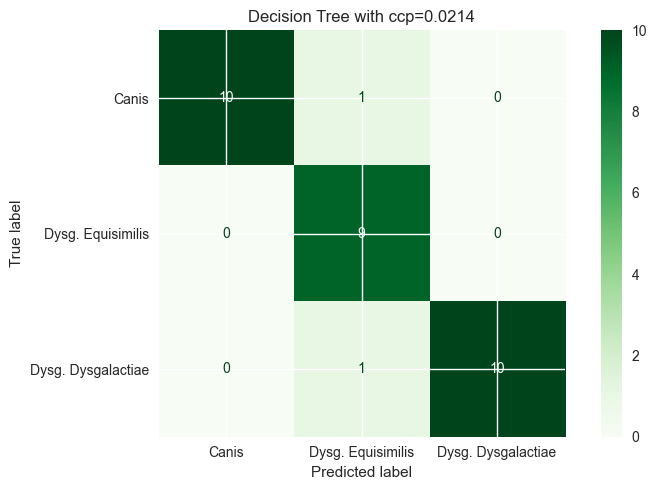

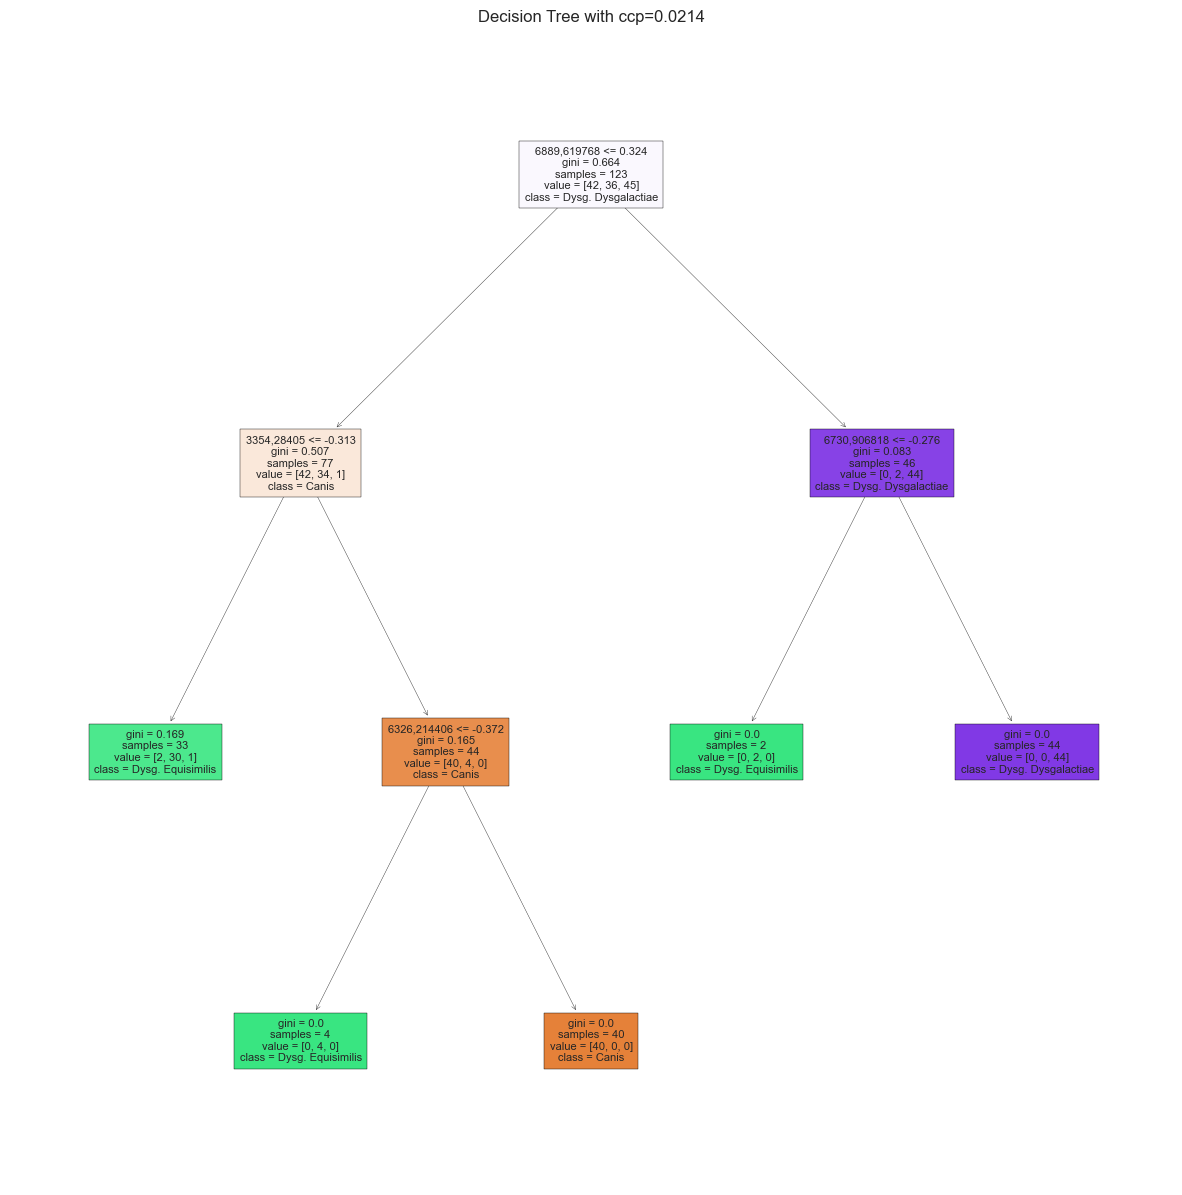

train accuracy score: 0.9756
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.82      1.00      0.90         9
           2       1.00      0.91      0.95        11

    accuracy                           0.94        31
   macro avg       0.94      0.94      0.93        31
weighted avg       0.95      0.94      0.94        31



In [64]:
dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)
dtc = dtc.fit(X=X_train, y=y_train)
print(f"Profonfità albero: {dtc.get_depth()}")

#Dizionario con importanza feature
feature_importances = dtc.feature_importances_
feature_index = X.columns
myDict = dict(zip(feature_index, feature_importances))
myDict = dict(sorted(myDict.items(), key=lambda item: item[1], reverse = False))

#Plot delle 15 feature con più importanza
series = pd.Series(data=myDict.values(), index=myDict.keys()).tail(10)
series.plot(kind="barh", figsize=(8, 5), title=f"Feature importances for basic Decision Tree", legend=None)
plt.tight_layout()
plt.show()

dtc_cv_scores = cross_val_score(estimator=dtc, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV accuracy: {dtc_cv_scores.mean():.4f} +/- {dtc_cv_scores.std():.4f}")
print(dtc_cv_scores)

fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(estimator=dtc, X=X_test, y_true=y_test, cmap='Greens', display_labels=class_names, ax=ax)
plt.title("Basic Decision Tree")
plt.tight_layout()
plt.show()

feature_names = feature_index

plt.figure(figsize=(15, 15))
plot_tree(decision_tree=dtc, 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, fontsize=8)
plt.title("Basic Decision Tree")
plt.show()

y_pred = dtc.predict(X=X_test)
accuracy_tree = accuracy_score(y_true=y_test, y_pred=y_pred)

y_pred_train = dtc.predict(X=X_train)
accuracy_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
print(f"train accuracy score: {accuracy_train:.4f}")

report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

path = dtc.cost_complexity_pruning_path(X=X_train, y=y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

dtcs = []
#Tuning per iperparametro ccp(alphas)
for ccp_alpha in ccp_alphas:
    dtc = DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=ccp_alpha)
    dtc.fit(X=X_train, y=y_train)
    dtcs.append(dtc)
    
train_scores = [dtc.score(X=X_train, y=y_train) for dtc in dtcs]
test_scores = [dtc.score(X=X_test, y=y_test) for dtc in dtcs]

alpha_scores_data = {"ccp": ccp_alphas.astype(str), "train": train_scores, "test": test_scores}

df_alpha_scores = pd.DataFrame(data=alpha_scores_data)
display(df_alpha_scores)

plt.figure(figsize=(7, 5))
sns.lineplot(x=ccp_alphas, y=train_scores, marker='o', label="train", drawstyle="steps-post")
sns.lineplot(x=ccp_alphas, y=test_scores, marker='o', label="test", drawstyle="steps-post")
plt.title("Accuracy vs alpha for training and testing sets of decision tree")
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.grid(linestyle='-.', linewidth=0.5)
plt.tight_layout()
plt.show()

dtc_bigccp = DecisionTreeClassifier(ccp_alpha=0.021465639876340106	, random_state=RANDOM_STATE)
dtc_bigccp = dtc_bigccp.fit(X=X_train, y=y_train)
print(f"Profonfità albero con ccp=0.0214: {dtc_bigccp.get_depth()}")

#Dizionario con importanza feature
feature_importances = dtc_bigccp.feature_importances_
feature_index = X.columns
myDict = dict(zip(feature_index, feature_importances))
myDict = dict(sorted(myDict.items(), key=lambda item: item[1], reverse = False))

#Plot delle 15 feature con più importanza
series = pd.Series(data=myDict.values(), index=myDict.keys()).tail(10)
series.plot(kind="barh", figsize=(8, 5), title=f"Feature importances con ccp=0.0214", legend=None)
plt.tight_layout()
plt.show()

dtc_cv_scores_bigccp = cross_val_score(estimator=dtc_bigccp, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV accuracy: {dtc_cv_scores_bigccp.mean():.4f} +/- {dtc_cv_scores_bigccp.std():.4f}")
print(dtc_cv_scores_bigccp)

fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(estimator=dtc_bigccp, X=X_test, y_true=y_test, cmap='Greens', display_labels=class_names, ax=ax)
plt.title("Decision Tree with ccp=0.0214")
plt.tight_layout()
plt.show()

feature_names = feature_index

plt.figure(figsize=(15, 15))
plot_tree(decision_tree=dtc_bigccp, 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, fontsize=8)
plt.title("Decision Tree with ccp=0.0214")
plt.show()

y_pred = dtc_bigccp.predict(X=X_test)
accuracy_tree_bigccp = accuracy_score(y_true=y_test, y_pred=y_pred)

y_pred_train = dtc_bigccp.predict(X=X_train)
accuracy_tree_train_bigccp = accuracy_score(y_true=y_train, y_pred=y_pred_train)
print(f"train accuracy score: {accuracy_tree_train_bigccp:.4f}")

report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

,depth,train,test
0,1,0.699187,0.677419
1,2,0.943089,0.935484
2,3,0.983740,0.935484
3,4,1.000000,0.935484
4,5,1.000000,0.935484
5,6,1.000000,0.935484
6,7,1.000000,0.935484
7,8,1.000000,0.935484
8,9,1.000000,0.935484


Profonfità albero: 1
Mean CV accuracy: 0.6990 +/- 0.0218
[0.72    0.72    0.68    0.70833 0.66667]
Profonfità albero: 7
Mean CV accuracy: 0.8867 +/- 0.0458
[0.8     0.88    0.92    0.91667 0.91667]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


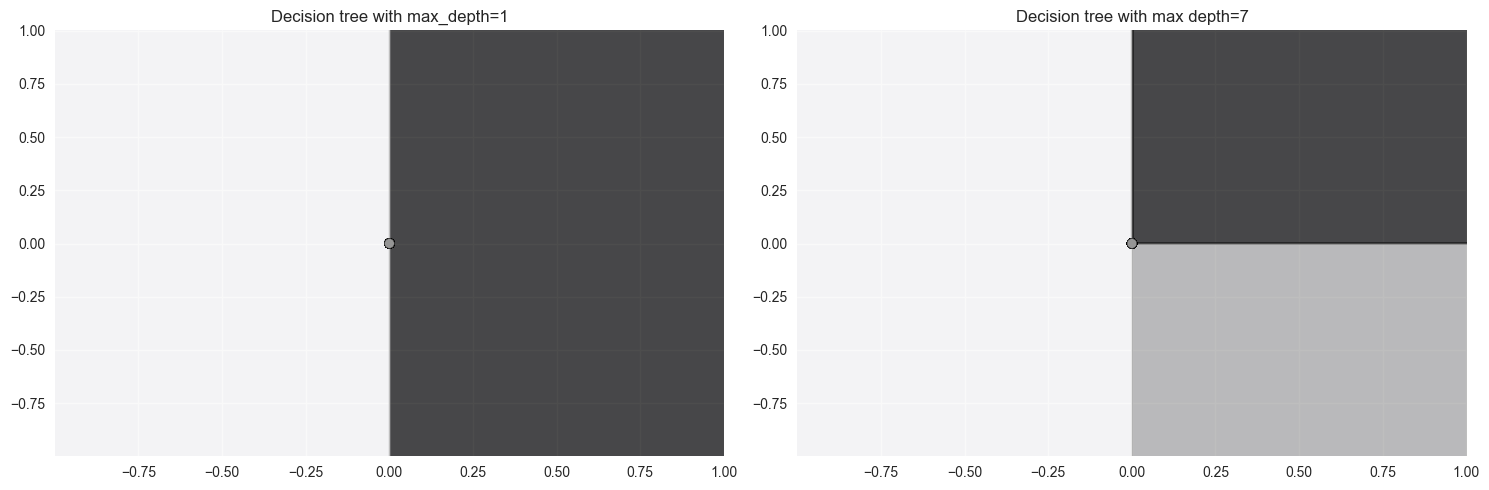

In [68]:
#Tuning per iperparametro altezza
dtcs = []
depths = range(1, 10)
for depth in depths:
    dtc_vardepth = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    dtc_vardepth.fit(X=X_train, y=y_train)
    dtcs.append(dtc_vardepth)
    
train_scores = [dtc_vardepth.score(X=X_train, y=y_train) for dtc_vardepth in dtcs]
test_scores = [dtc_vardepth.score(X=X_test, y=y_test) for dtc_vardepth in dtcs]

alpha_scores_data = {"depth": depths, "train": train_scores, "test": test_scores}
df_alpha_scores = pd.DataFrame(data=alpha_scores_data)
display(df_alpha_scores)

X_dtc = maldi[['6889,619768','3354,28405']].values
y_dtc = df[['target']].values
X_train_dtc, X_test_dtc, y_train_dtc, y_test_dtc = train_test_split(
    X_dtc, y_dtc, test_size=0.2, random_state=42, stratify=y)

dtc_small = DecisionTreeClassifier(max_depth=1)
dtc_small.fit(X=X_train_dtc, y=y_train_dtc)
print(f"Profonfità albero: {dtc_small.get_depth()}")

dtc_cv_scores_small_2feat = cross_val_score(estimator=dtc_small, X=X_train_dtc, y=y_train_dtc, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV accuracy: {dtc_cv_scores_small_2feat.mean():.4f} +/- {dtc_cv_scores_small_2feat.std():.4f}")
print(dtc_cv_scores_small_2feat)

dtc_big = DecisionTreeClassifier()
dtc_big.fit(X=X_train_dtc, y=y_train_dtc)
print(f"Profonfità albero: {dtc_big.get_depth()}")

dtc_cv_scores_big_2feat = cross_val_score(estimator=dtc_big, X=X_train_dtc, y=y_train_dtc, 
                                    scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV accuracy: {dtc_cv_scores_big_2feat.mean():.4f} +/- {dtc_cv_scores_big_2feat.std():.4f}")
print(dtc_cv_scores_big_2feat)

fig = plt.figure(figsize=(15, 5))
ax = fig.subplots(nrows=1, ncols=2)
db_small = DecisionBoundaryDisplay.from_estimator(estimator=dtc_small, X=X_dtc, grid_resolution=200, alpha=0.75, ax=ax[0])
db_big = DecisionBoundaryDisplay.from_estimator(estimator=dtc_big, X=X_dtc, grid_resolution=200, alpha=0.75, ax=ax[1])
db_small.ax_.scatter(X_dtc[:, 0], X_dtc[:, 1], c=y, edgecolor="k")
db_big.ax_.scatter(X_dtc[:, 0], X_dtc[:, 1], c=y, edgecolor="k")
ax[0].set_title("Decision tree with max_depth=1")
ax[1].set_title(f"Decision tree with max depth={dtc_big.get_depth()}")
plt.tight_layout()
plt.show()

,# neighbors,accuracy
0,1,0.967742
1,3,0.967742
2,5,0.967742
3,7,0.935484
4,9,0.935484
...,...,...
56,113,0.483871
57,115,0.451613
58,117,0.387097
59,119,0.354839


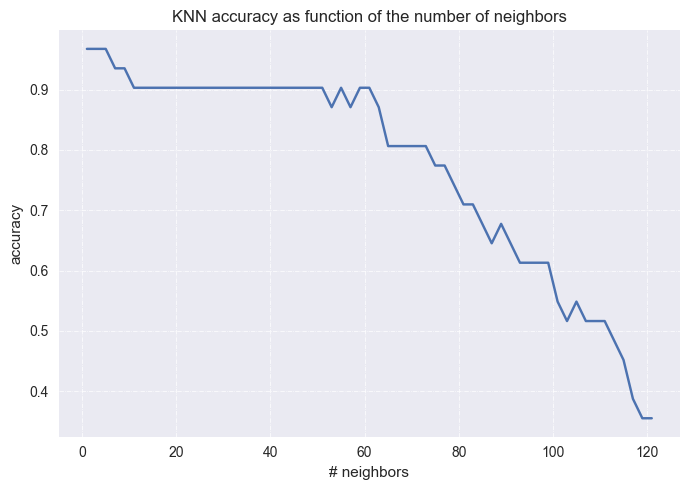

,# neighbors,accuracy
0,1,0.967742
1,3,0.967742
2,5,0.967742


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Mean CV KNN accuracy: 0.9267 +/- 0.0533
[1.      0.84    0.96    0.91667 0.91667]


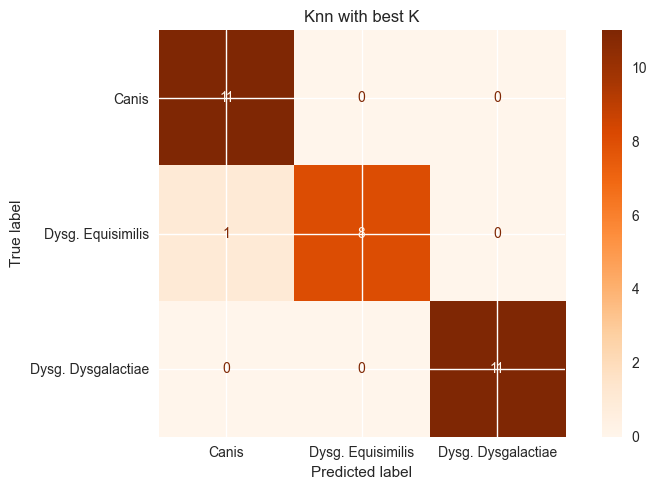

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.89      0.94         9
           2       1.00      1.00      1.00        11

    accuracy                           0.97        31
   macro avg       0.97      0.96      0.97        31
weighted avg       0.97      0.97      0.97        31



In [66]:
knn_scores = []

for k in range(1, X_train.shape[0], 2):
    # model definition and training
    knn =  KNeighborsClassifier(n_neighbors=k)
    knn.fit(X=X_train, y=y_train)
    # compute accuracy on test set
    accuracy = knn.score(X_test, y_test)
    # store the results on a list of dictionaries
    metrics = {"# neighbors": k, "accuracy": accuracy}
    knn_scores.append(metrics)

# convert the list of dictionaries to pandas dataframe
df_knn_scores = pd.DataFrame(data=knn_scores)    #molto facile eveloce da dizionario a dataframe 
display(df_knn_scores)

mask = df_knn_scores["accuracy"] == df_knn_scores["accuracy"].max()
knn_k = df_knn_scores['accuracy'].idxmax()
n = df_knn_scores['# neighbors'][knn_k]

plt.figure(figsize=(7, 5))
plt.title("KNN accuracy as function of the number of neighbors")
sns.lineplot(x="# neighbors", y="accuracy", data=df_knn_scores)
plt.grid(linestyle='-.', linewidth=0.5)
plt.tight_layout()
plt.show()

display(df_knn_scores[mask])

knn = KNeighborsClassifier(n_neighbors=n)
knn.fit(X=X_train, y=y_train)

knn_cv_scores = cross_val_score(estimator=knn, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV KNN accuracy: {knn_cv_scores.mean():.4f} +/- {knn_cv_scores.std():.4f}")
print(knn_cv_scores)

fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(estimator=knn, X=X_test, y_true=y_test, cmap='Oranges', display_labels=class_names, ax=ax)
plt.title("Knn with best K")
plt.tight_layout()
plt.show()

y_pred = knn.predict(X=X_test)
accuracy_knn = accuracy_score(y_true=y_test, y_pred=y_pred)
report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Mean CV Random Forest accuracy: 0.9513 +/- 0.0157
[0.96    0.92    0.96    0.95833 0.95833]
Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy', 'class_weight': None}
Random Forest Score:  0.9756666666666668


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Mean CV Best Random Forest accuracy: 0.9757 +/- 0.0199
[1.      0.96    0.96    0.95833 1.     ]


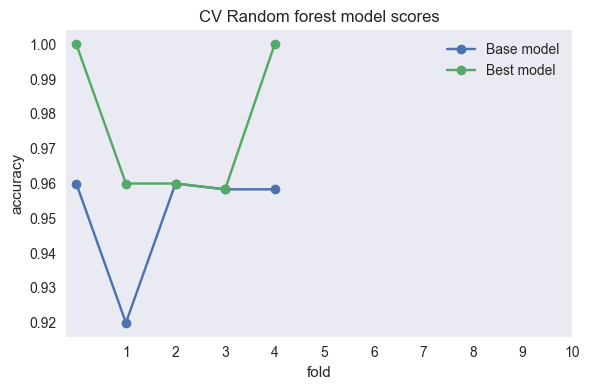

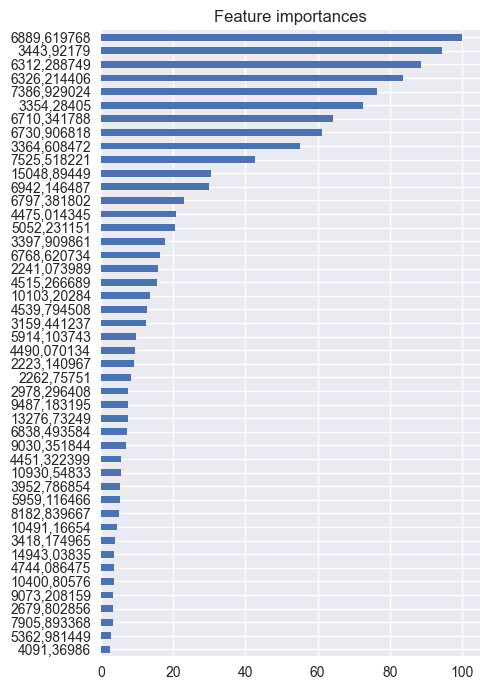

Score:  0.959349593495935


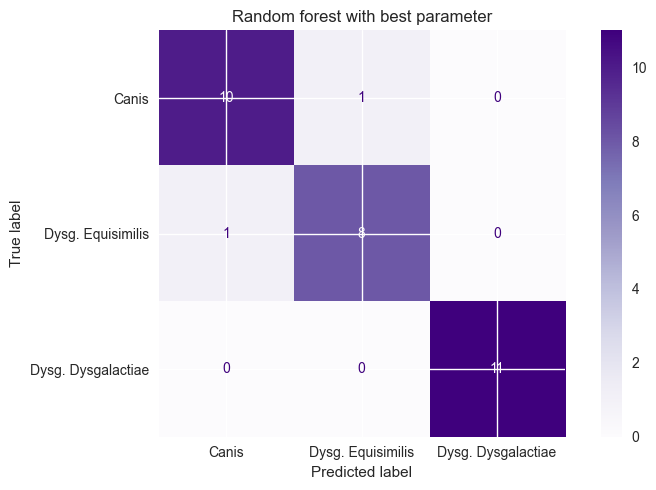

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.89      0.89      0.89         9
           2       1.00      1.00      1.00        11

    accuracy                           0.94        31
   macro avg       0.93      0.93      0.93        31
weighted avg       0.94      0.94      0.94        31

R2 score of random forest classifier on test set: 0.909
Mean squared error of random forest classifier on test set: 0.254


In [69]:
rm = RandomForestClassifier(oob_score=True, n_jobs=N_JOBS, random_state=RANDOM_STATE)
rm_cv_scores = cross_val_score(estimator=rm, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV Random Forest accuracy: {rm_cv_scores.mean():.4f} +/- {rm_cv_scores.std():.4f}")
print(rm_cv_scores)

params = {
    "n_estimators": [25, 50, 100, 200, 250, 500],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 1, 2, 5, 10, 20],
    "max_features": ["sqrt", "log2"],
    "class_weight": [None, "balanced", "balanced_subsample"]
}
#
random_search = RandomizedSearchCV(estimator=rm, param_distributions=params, n_iter=20, 
                                   scoring="accuracy", n_jobs=N_JOBS, cv=skfold, verbose=1, random_state=RANDOM_STATE)
random_search.fit(X=X_train, y=y_train)
print(random_search.best_params_)
print('Random Forest Score: ', random_search.best_score_)

#n_estimators': 200, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy', 'class_weight': None}
n_estimator = 200
max_features = 'sqrt'
max_depth = None
criterion = 'entropy'
class_weight = None
best_rm = RandomForestClassifier(n_estimators=n_estimator, max_features=max_features, max_depth=max_depth, class_weight=class_weight, criterion=criterion, oob_score=True, n_jobs=N_JOBS, random_state=RANDOM_STATE)
best_rm.fit(X=X_train, y=y_train)
best_rm_cv_scores = cross_val_score(estimator=best_rm, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV Best Random Forest accuracy: {best_rm_cv_scores.mean():.4f} +/- {best_rm_cv_scores.std():.4f}")
print(best_rm_cv_scores)

plt.figure(figsize=(6, 4))
plt.title("CV Random forest model scores")
plt.plot(rm_cv_scores, marker="o")
plt.plot(best_rm_cv_scores, marker="o")
plt.xticks(ticks=range(1, 11))
plt.xlabel("fold")
plt.ylabel("accuracy")
plt.legend(["Base model", "Best model"])
plt.tight_layout()
plt.grid()
plt.show()

feature_importances_plot(model=best_rm, labels=X.columns)
print("Score: ", best_rm.oob_score_)

fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(estimator=best_rm, X=X_test, y_true=y_test, cmap='Purples', display_labels=class_names, ax=ax)
plt.title("Random forest with best parameter")
plt.tight_layout()
plt.show()

y_pred = best_rm.predict(X_test)
accuracy_rm = accuracy_score(y_true=y_test, y_pred=y_pred)

report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

r2_rf = r2_score(y_test, y_pred)
print('R2 score of random forest classifier on test set: {:.3f}'.format(r2_rf))

rmse_rf = mean_squared_error(y_test, y_pred, squared=False)
print('Mean squared error of random forest classifier on test set: {:.3f}'.format(rmse_rf))